In [1]:
import cv2, pickle
from PIL import Image, ImageFilter
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from skimage import io, color, feature, filters, restoration, exposure
import os
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tqdm import tqdm
from skimage import util, io, transform

## Original Image

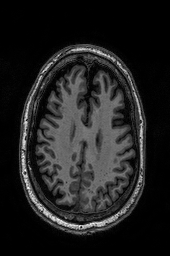

In [2]:
image = Image.open("/kaggle/input/adni-extracted-axial/Axial/AD/AD002_S_0816a076.png")
image

## Gaussian Blurring

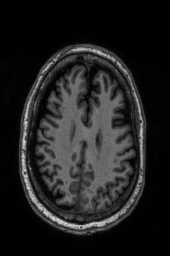

In [3]:
# Apply GaussianBlur filter with radius of 2 pixels
denoise_image = image.filter(ImageFilter.GaussianBlur(radius=0.5))
denoise_image

## Edge Enhancement

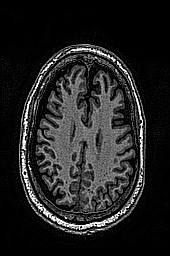

In [4]:
# Apply edge enhancement
edge_enhance_image = denoise_image.filter(ImageFilter.EDGE_ENHANCE)
edge_enhance_image

## Texture Analysis

In [5]:
texture_analysis_org = pd.DataFrame(columns=['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation'])

### Texture Analysis for Original Image

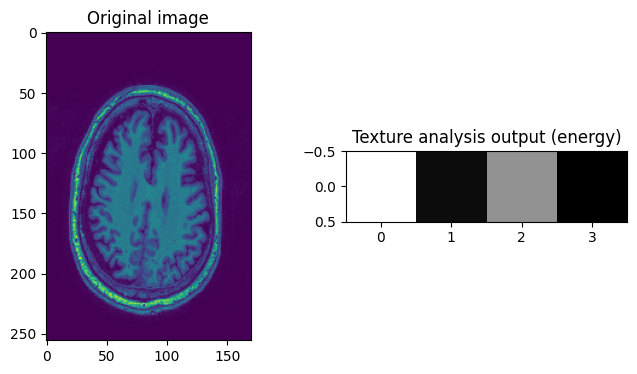

In [7]:
# Load the image
image = io.imread("/kaggle/input/adni-extracted-axial/Axial/AD/AD002_S_0816a076.png")

# Convert the image to grayscale
gray_image = image

# Compute the GLCM
glcm = feature.graycomatrix(gray_image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

# Compute texture features from the GLCM
contrast = feature.graycoprops(glcm, 'contrast')
dissimilarity = feature.graycoprops(glcm, 'dissimilarity')
homogeneity = feature.graycoprops(glcm, 'homogeneity')
energy = feature.graycoprops(glcm, 'energy')
correlation = feature.graycoprops(glcm, 'correlation')


### storing features
texture_analysis_org['contrast'] = contrast[0]
texture_analysis_org['dissimilarity'] = dissimilarity[0]
texture_analysis_org['homogeneity'] = homogeneity[0]
texture_analysis_org['energy'] = energy[0]
texture_analysis_org['correlation'] = correlation[0]

texture_analysis_org.set_index(pd.Index(['color label 0', 'color label 1', 'color label 2', 'color label 3']), inplace=True)

# Display the output image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].imshow(image)
ax[0].set_title("Original image")
plt.imshow(energy, cmap='gray')
ax[1].set_title("Texture analysis output (energy)")
plt.show()

### Texture Analysis for Edge Enhanced Image

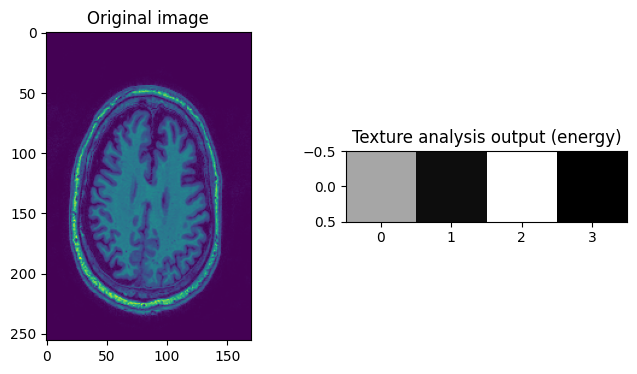

In [8]:
texture_analysis_processed = pd.DataFrame(columns=['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation'])
# Convert the image to grayscale
gray_image = np.array(edge_enhance_image)

# Compute the GLCM
glcm = feature.graycomatrix(gray_image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

# Compute texture features from the GLCM
contrast = feature.graycoprops(glcm, 'contrast')
dissimilarity = feature.graycoprops(glcm, 'dissimilarity')
homogeneity = feature.graycoprops(glcm, 'homogeneity')
energy = feature.graycoprops(glcm, 'energy')
correlation = feature.graycoprops(glcm, 'correlation')


### storing features
texture_analysis_processed['contrast'] = contrast[0]
texture_analysis_processed['dissimilarity'] = dissimilarity[0]
texture_analysis_processed['homogeneity'] = homogeneity[0]
texture_analysis_processed['energy'] = energy[0]
texture_analysis_processed['correlation'] = correlation[0]

texture_analysis_processed.set_index(pd.Index(['color label 0', 'color label 1', 'color label 2', 'color label 3']), inplace=True)


# Display the output image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].imshow(image)
ax[0].set_title("Original image")
ax[1].imshow(energy, cmap='gray')
ax[1].set_title("Texture analysis output (energy)")
plt.show()

### Texture Features of Original AD Image

In [9]:
texture_analysis_org.style.background_gradient(cmap='viridis')

,contrast,dissimilarity,homogeneity,energy,correlation
color label 0,298.517775,8.149940,0.452147,0.282647,0.923085
color label 1,413.193572,9.720872,0.438236,0.277166,0.893727
color label 2,227.197463,6.990311,0.456249,0.280186,0.941398
color label 3,426.440121,9.764636,0.439412,0.276885,0.890320


### Texture Features of Processed (Edge Enhanced) AD Image

In [10]:
texture_analysis_processed.style.background_gradient(cmap='viridis')

,contrast,dissimilarity,homogeneity,energy,correlation
color label 0,1480.068810,18.584204,0.401870,0.342430,0.748668
color label 1,1969.152500,21.931663,0.382587,0.328984,0.666383
color label 2,1096.474418,15.871880,0.413746,0.350229,0.813565
color label 3,1975.258452,21.907251,0.381608,0.327807,0.665349


### **DATA PREPROCESSING**

#### original Image ---> Gaussian Blurring (Denoising) ---> Edge Enhancement ---> Intensity Normalization ---> Contrast Enhancement

In [11]:
def refine_image(image):
    image = Image.open(image)

    ## denoising
    denoise_image = image.filter(ImageFilter.GaussianBlur(radius=0.5))

    ## Edge Enhancement
    edge_enhance_image = denoise_image.filter(ImageFilter.EDGE_ENHANCE)

    ## Intensity Normalization
    image_norm = exposure.equalize_hist(np.array(edge_enhance_image))

    ## Contrast Enhncement
    image_contrast = exposure.rescale_intensity(image_norm)

    return image_contrast


In [12]:
# This cell should be run only when preprocessing needs to be done again

AD_original = glob('/kaggle/input/adni-extracted-axial/Axial/AD/*')
CI_original = glob('/kaggle/input/adni-extracted-axial/Axial/CI/*')
CN_original = glob('/kaggle/input/adni-extracted-axial/Axial/CN/*')

AD_processed = []
CI_processed = []
CN_processed = []

for i in range(len(CI_original)):
    try:
        img = AD_original[i]
        AD_processed.append(refine_image(img))
    except:
        pass

    try:
        img = CI_original[i]
        CI_processed.append(refine_image(img))
    except:
        pass

    try:
        img = CN_original[i]
        CN_processed.append(refine_image(img))
    except:
        pass


In [13]:
# This cell will store the preprocessed images in the form of pickle; if already stored, don't run again
import pickle
with open('/kaggle/working/AD_processed_dump.pkl', 'wb') as f:
    pickle.dump(AD_processed, f)

with open('/kaggle/working/CI_processed_dump.pkl', 'wb') as f:
    pickle.dump(CI_processed, f)

with open('/kaggle/working/CN_processed_dump.pkl', 'wb') as f:
    pickle.dump(CN_processed, f)

In [15]:
# Loading the saved pickle data
with open('/kaggle/working/AD_processed_dump.pkl', 'rb') as f:
    AD_processed_loaded = pickle.load(f)

with open('/kaggle/working/CI_processed_dump.pkl', 'rb') as f:
    CI_processed_loaded = pickle.load(f)

with open('/kaggle/working/CN_processed_dump.pkl', 'rb') as f:
    CN_processed_loaded = pickle.load(f)

In [16]:
len(AD_processed_loaded), len(CI_processed_loaded), len(CN_processed_loaded)

(1124, 2590, 1440)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


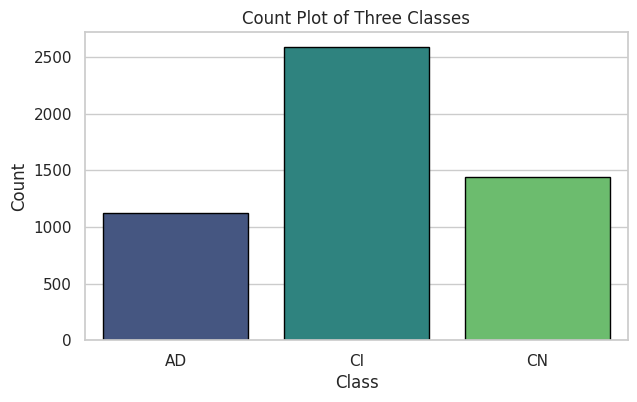

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# AD_processed_loaded, CI_processed_loaded, CN_processed_loaded are your datasets
AD_count = len(AD_processed_loaded)
CI_count = len(CI_processed_loaded)
CN_count = len(CN_processed_loaded)

# Create a list of class labels and their corresponding counts
class_labels = ['AD', 'CI', 'CN']
class_counts = [AD_count, CI_count, CN_count]

# Create a count plot with black edge
sns.set(style="whitegrid")
plt.figure(figsize=(7,4))
sns.barplot(x=class_labels, y=class_counts, palette="viridis", edgecolor='black')

plt.title('Count Plot of Three Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

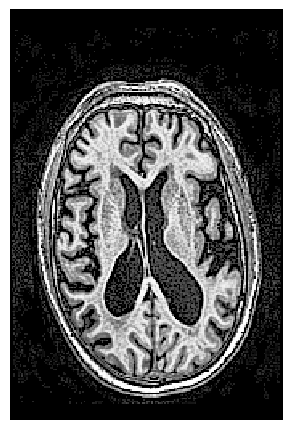

In [18]:
io.imshow(AD_processed_loaded[0])
plt.axis('off')
io.show()

#### Original Vs Preprocessed Data Overview

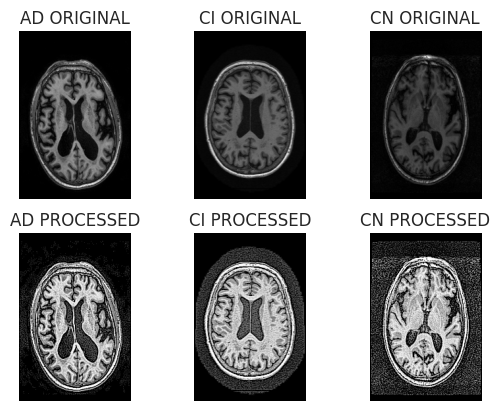

In [19]:
# Load the images
img1 = Image.open(AD_original[0])
img2 = Image.open(CI_original[0])
img3 = Image.open(CN_original[0])

img1 = np.array(img1)
img2 = np.array(img2)
img3 = np.array(img3)

# Resize the images
img1 = transform.resize(img1, img3.shape)
img2 = transform.resize(img2, img3.shape)

# Load the images
proc_img1 = AD_processed_loaded[0]
proc_img2 = CI_processed_loaded[0]
proc_img3 = CN_processed_loaded[0]

# Resize the images
proc_img1 = transform.resize(proc_img1, proc_img3.shape)
proc_img2 = transform.resize(proc_img2, proc_img3.shape)

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=2, ncols=3)

# Display the images and set the titles
axes[0,0].imshow(img1, cmap='gray')
axes[0,0].set_title('AD ORIGINAL')
axes[0,0].axis('off')

axes[0,1].imshow(img2,  cmap='gray')
axes[0,1].set_title('CI ORIGINAL')
axes[0,1].axis('off')

axes[0,2].imshow(img3, cmap='gray')
axes[0,2].set_title('CN ORIGINAL')
axes[0,2].axis('off')


# Display the images and set the titles
axes[1,0].imshow(proc_img1, cmap='gray')
axes[1,0].set_title('AD PROCESSED')
axes[1,0].axis('off')

axes[1,1].imshow(proc_img2,  cmap='gray')
axes[1,1].set_title('CI PROCESSED')
axes[1,1].axis('off')

axes[1,2].imshow(proc_img3, cmap='gray')
axes[1,2].set_title('CN PROCESSED')
axes[1,2].axis('off')

# Display the figure
plt.show()

## Feature Extraction: VGG16

This step involved the extraction of image salient features using pretrained VGG16 model. This aims to reduce the complexity of images by conserving only relevant features using VGG knowledge base.

In [20]:
# images = AD_processed_loaded + CI_processed_loaded + CN_processed_loaded

# load the model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summary
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


### Resizing images & Additional Preprocessing

This step involves resizing of images and increasing the colour channel from 2 to 3. From variable image shapes to (224,224,3) which is the desired input shape for VGG16 model. To add the third channel, the padding is done by adding 0s to the last channel. Further, cropping is done.

In [21]:
def _compatible(list_of_images):
  new_set_images = []
  for i in tqdm(range(len(list_of_images))):
    img_array_2d = list_of_images[i]

    # Expand the dimensions to create a 3D image
    img_array_3d = np.expand_dims(img_array_2d, axis=-1)

    # Repeat the values along the new dimension (here, 3 channels for RGB)
    img_array_3d = np.repeat(img_array_3d, 3, axis=-1)

    # Define the target size
    target_size = (224, 224)

    # Calculate the padding values for height and width
    pad_height = (target_size[0] - img_array_3d.shape[0]) // 2
    pad_width = (target_size[1] - img_array_3d.shape[1]) // 2

    if pad_height<0:
      pad_height=0
    if pad_width<0:
      pad_width=0

    # Apply padding
    padded_image = np.pad(img_array_3d, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')


    img = padded_image  # Replace this with your actual image array


    # Define the target size
    target_size = (224, 224, 3)

    # Calculate the amount of pixels to be removed from each edge
    remove_pixels_vertical = (img.shape[0] - target_size[0]) // 2
    remove_pixels_horizontal = (img.shape[1] - target_size[1]) // 2

    if remove_pixels_horizontal != 0 and remove_pixels_vertical !=0:
      cropped_image = img[remove_pixels_vertical:-(remove_pixels_vertical), remove_pixels_horizontal:-(remove_pixels_horizontal), :]
    elif remove_pixels_horizontal == 0:
      cropped_image = img[remove_pixels_vertical:-(remove_pixels_vertical),:,:]
    elif remove_pixels_vertical == 0:
      cropped_image = img[:,:,remove_pixels_horizontal:-(remove_pixels_horizontal)]

    if cropped_image.shape[0]!=224 and cropped_image.shape[1]!=224:
      print("something wrong")

    new_set_images.append(cropped_image)

  return new_set_images

In [23]:
AD_images = _compatible(AD_processed_loaded)
with open('/kaggle/working/AD_processed_reshaped.pkl', 'wb') as f:
    pickle.dump(AD_images, f)

100%|██████████| 1124/1124 [00:02<00:00, 530.87it/s]


In [24]:
CI_images = _compatible(CI_processed_loaded)
with open('/kaggle/working/CI_processed_reshaped.pkl', 'wb') as f:
    pickle.dump(CI_images, f)

100%|██████████| 2590/2590 [00:03<00:00, 715.39it/s] 


In [25]:
CN_images = _compatible(CN_processed_loaded)
with open('/kaggle/working/CN_processed_reshaped.pkl', 'wb') as f:
    pickle.dump(CN_images, f)

100%|██████████| 1440/1440 [00:04<00:00, 314.70it/s]


In [26]:
with open('/kaggle/working/AD_processed_reshaped.pkl', 'rb') as f:
    AD_processed_reshaped = pickle.load(f)

with open('/kaggle/working/CI_processed_reshaped.pkl', 'rb') as f:
    CI_processed_reshaped = pickle.load(f)

with open('/kaggle/working/CN_processed_reshaped.pkl', 'rb') as f:
    CN_processed_reshaped = pickle.load(f)

#### Feature Extraction AD Images

In [27]:
features_AD, features_CI, features_CN = [], [], []
from tqdm import tqdm

# FEATURE EXTRACTION AD IMAGES
for image in tqdm(AD_processed_reshaped):
    img = image
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)

    # extract features
    feature = model.predict(img, verbose=0)
    features_AD.append(feature)

100%|██████████| 1124/1124 [07:02<00:00,  2.66it/s]


In [28]:
with open('/kaggle/working/features_AD.pkl', 'wb') as f:
    pickle.dump(features_AD, f)

#### Feature Extraction CI Images

In [29]:
# FEATURE EXTRACTION CI IMAGES
for image in tqdm(CI_processed_reshaped):
    img = image
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)

    # extract features
    feature = model.predict(img, verbose=0)
    features_CI.append(feature)

100%|██████████| 2590/2590 [16:25<00:00,  2.63it/s]


In [30]:
with open('/kaggle/working/features_CI.pkl', 'wb') as f:
    pickle.dump(features_CI, f)

#### Feature Extraction CN Images

In [31]:
# FEATURE EXTRACTION CN IMAGES
for image in tqdm(CN_processed_reshaped):
    img = image
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)

    # extract features
    feature = model.predict(img, verbose=0)
    features_CN.append(feature)

100%|██████████| 1440/1440 [09:09<00:00,  2.62it/s]


In [32]:
with open('/kaggle/working/features_CN.pkl', 'wb') as f:
    pickle.dump(features_CN, f)

In [33]:
with open('/kaggle/working/features_AD.pkl', 'rb') as f:
    features_AD = pickle.load(f)

with open('/kaggle/working/features_CI.pkl', 'rb') as f:
    features_CI = pickle.load(f)

with open('/kaggle/working/features_CN.pkl', 'rb') as f:
    features_CN = pickle.load(f)

In [34]:
print("Total number of data samples for class AD: ", len(features_AD))
print("Total number of data samples for class CI: ", len(features_CI))
print("Total number of data samples for class CN: ", len(features_CN))

Total number of data samples for class AD:  1124
Total number of data samples for class CI:  2590
Total number of data samples for class CN:  1440


In [35]:
print("Shape of Image after feature extraction: ", features_CI[0].shape)

Shape of Image after feature extraction:  (1, 4096)


### Data Splitting: Train & Test

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# labels for AD, CI, and CN
labels_AD = ['AD'] * len(features_AD)
labels_CI = ['CI'] * len(features_CI)
labels_CN = ['CN'] * len(features_CN)

# Combine features and labels
all_features = np.vstack((features_AD, features_CI, features_CN))
all_labels = np.concatenate((labels_AD, labels_CI, labels_CN))

# Encode labels
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)
all_labels_encoded = all_labels_encoded.astype('int64')

all_labels_encoded = to_categorical(all_labels_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    all_features, all_labels_encoded, test_size=0.2, random_state=42
)

# Reshape input for 1D CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], 1)


print("Shape of Train X: ", X_train.shape)
print("Shape of Test X: ", X_test.shape)

Shape of Train X:  (4123, 4096, 1)
Shape of Test X:  (1031, 4096, 1)


In [37]:
y_test

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

## Custom CNN

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score, roc_auc_score

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


# Define the 1D CNN model
model = tf.keras.Sequential([

    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(4096, 1)),
    tf.keras.layers.MaxPooling1D(2),

    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes (AD, CI, CN)
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4094, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2047, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2045, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1022, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65408)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,372,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,379,075 (31.96 MB)

 Trainable params: 8,379,075 (31.96 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Train the model with early stopping
history_cnn = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.4525 - loss: 1.8936 - val_accuracy: 0.4665 - val_loss: 1.0575
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.5030 - loss: 1.0397 - val_accuracy: 0.4665 - val_loss: 1.0605
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - accuracy: 0.5100 - loss: 1.0278 - val_accuracy: 0.4665 - val_loss: 1.0563
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.5121 - loss: 1.0250 - val_accuracy: 0.4665 - val_loss: 1.0576
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.5047 - loss: 1.0307 - val_accuracy: 0.4665 - val_loss: 1.0597
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.5064 - loss: 1.0287 - val_accuracy: 0.4665 - val_loss: 1.0602
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.5242 - loss: 1.0165 - val_accuracy: 0.4665 - val_loss: 1.0556
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.5185 - loss: 1

In [41]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)


# Decoding y_test
y_test_dec = np.argmax(y_test, axis=-1)
y_test_labels = label_encoder.inverse_transform(y_test_dec)
# Make predictions
predictions = np.argmax(model.predict(X_test), axis=-1)
predicted_labels = label_encoder.inverse_transform(predictions)


prec_cnn = precision_score(y_test_labels, predicted_labels, average='weighted')
rec_cnn = recall_score(y_test_labels, predicted_labels, average='weighted')
f1_cnn = f1_score(y_test_labels, predicted_labels, average='weighted')
acc_cnn = accuracy_score(y_test_labels, predicted_labels)

print(f"Test Accuracy: {acc_cnn}")
print(f"Test Precision: {prec_cnn}")
print(f"Test Recall: {rec_cnn}")
print(f"Test F1 Score: {f1_cnn}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7519 - loss: 0.5955
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test Accuracy: 0.7565470417070805
Test Precision: 0.757012300340013
Test Recall: 0.7565470417070805
Test F1 Score: 0.7555404346367612


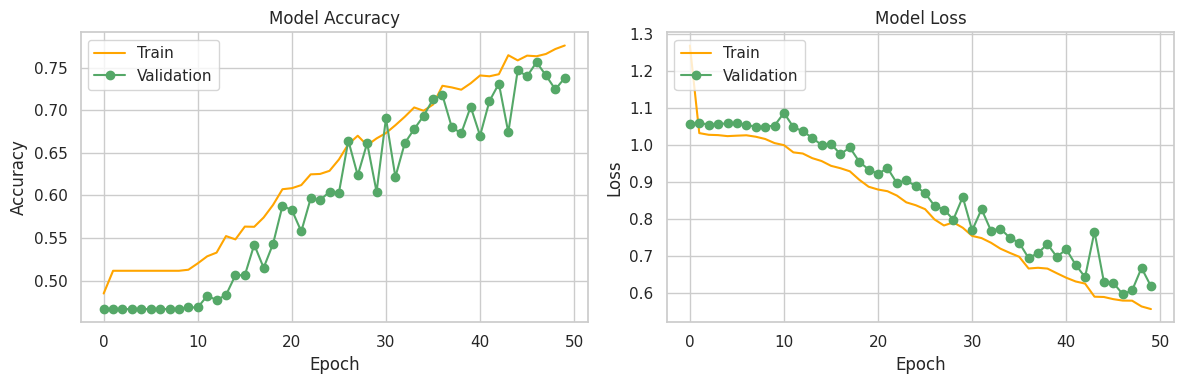

In [42]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], c='orange')
plt.plot(history_cnn.history['val_accuracy'], 'o-', c='g')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], c='orange')
plt.plot(history_cnn.history['val_loss'], 'o-', c='g')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

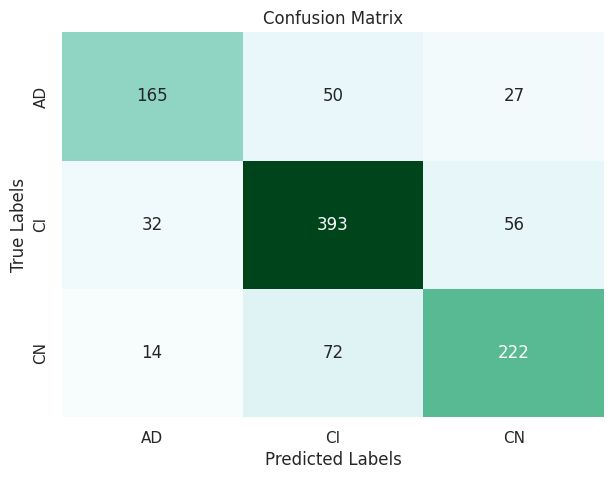

In [43]:
# Plot confusion matrix
plt.figure(figsize=(7, 5))
conf_matrix = confusion_matrix(y_test_labels, predicted_labels)
unique_labels = np.unique(np.concatenate((y_test_labels, predicted_labels)))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuGn', cbar=False, xticklabels=unique_labels, yticklabels=unique_labels)
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## ExtraTrees

In [44]:
# Labels for AD, CI, and CN
labels_AD = [1] * len(features_AD)
labels_CI = [2] * len(features_CI)
labels_CN = [3] * len(features_CN)

# Combine features and labels
all_features = np.vstack((np.array(features_AD).reshape(len(features_AD), -1),
                          np.array(features_CI).reshape(len(features_CI), -1),
                          np.array(features_CN).reshape(len(features_CN), -1)))
all_labels = np.concatenate((labels_AD, labels_CI, labels_CN))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    all_features, all_labels, test_size=0.2, random_state=42
)

In [45]:
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score


# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
}


# Initialize the ExtraTrees Classifier
extra_trees_classifier = ExtraTreesClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    extra_trees_classifier, param_distributions=param_dist, n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", random_search.best_params_)

# Get the best estimator from the search
best_extra_trees_classifier = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'criterion': 'gini'}


In [46]:
# Make predictions on the test set
predictions = best_extra_trees_classifier.predict(X_test)

prec_et = precision_score(y_test, predictions, average='weighted')
rec_et = recall_score(y_test, predictions, average='weighted')
f1_et = f1_score(y_test, predictions, average='weighted')
acc_et = accuracy_score(y_test, predictions)

print(f"Test Accuracy: {acc_et}")
print(f"Test Precision: {prec_et}")
print(f"Test Recall: {rec_et}")
print(f"Test F1 Score: {f1_et}")

Test Accuracy: 0.9941804073714839
Test Precision: 0.994224396061823
Test Recall: 0.9941804073714839
Test F1 Score: 0.9941736130193447


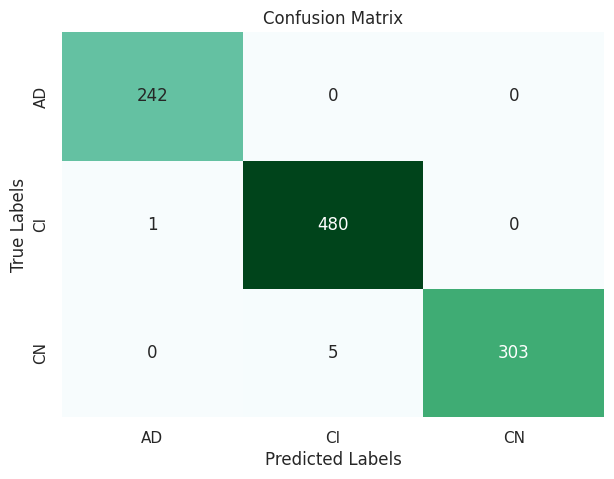

In [47]:
# Plot confusion matrix
plt.figure(figsize=(7, 5))
conf_matrix = confusion_matrix(y_test, predictions)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuGn', cbar=False, xticklabels=['AD', 'CI', 'CN'], yticklabels=['AD', 'CI', 'CN'])
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from keras.layers import Input, Dense
from keras.models import Model

# 1. Data Preparation
features_all = np.concatenate([features_AD, features_CI, features_CN], axis=0)
labels_all = np.concatenate([np.zeros(len(features_AD)), np.ones(len(features_CI)), np.ones(len(features_CN))*2])

# 2. Reshape the data to 2D
features_all_2d = features_all.reshape(features_all.shape[0], -1)

# 3. Standardize the data
scaler = StandardScaler()
features_all_scaled = scaler.fit_transform(features_all_2d)

In [49]:
# Autoencoder
input_dim = features_all_scaled.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history_encoder = autoencoder.fit(features_all_scaled, features_all_scaled, epochs=50, batch_size=256, shuffle=True)

# 5. Extract Features
encoder = Model(input_layer, encoded)
features_encoded = encoder.predict(features_all_scaled)

# 6. Classifier
X_train, X_test, y_train, y_test = train_test_split(features_encoded, labels_all, test_size=0.2, random_state=40, stratify=labels_all)

classifier = ExtraTreesClassifier(n_estimators=200, random_state=42, min_samples_split= 2, min_samples_leaf= 1, max_features= None, max_depth= 30, criterion= 'gini')
classifier.fit(X_train, y_train)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5116
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2873
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2629
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2498
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2392
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2418
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2355
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2320
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2329
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2266
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2339
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2213
Epoch 13/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2350
Epoch 14/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2298
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2246
Epoc

ExtraTreesClassifier(max_depth=30, max_features=None, n_estimators=200,
                     random_state=42)

In [50]:
encoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       262,208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,208 (1.00 MB)

 Trainable params: 262,208 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Make predictions
y_pred = classifier.predict(X_test)

prec_encoder = precision_score(y_test, y_pred, average='weighted')
rec_encoder = recall_score(y_test, y_pred, average='weighted')
f1_encoder = f1_score(y_test, y_pred, average='weighted')
acc_encoder = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {acc_encoder}")
print(f"Test Precision: {prec_encoder}")
print(f"Test Recall: {rec_encoder}")
print(f"Test F1 Score: {f1_encoder}")

Test Accuracy: 0.9835111542192047
Test Precision: 0.9836580404888899
Test Recall: 0.9835111542192047
Test F1 Score: 0.9835162920397608


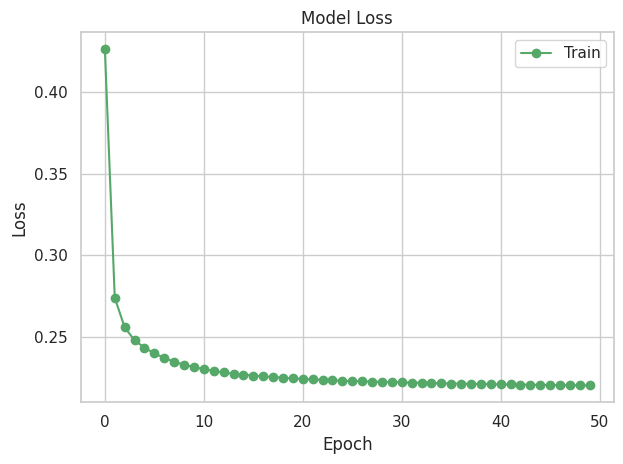

In [52]:
# Plot training & validation loss values
plt.plot(history_encoder.history['loss'], 'o-', c='g')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper right')

plt.tight_layout()
plt.show()

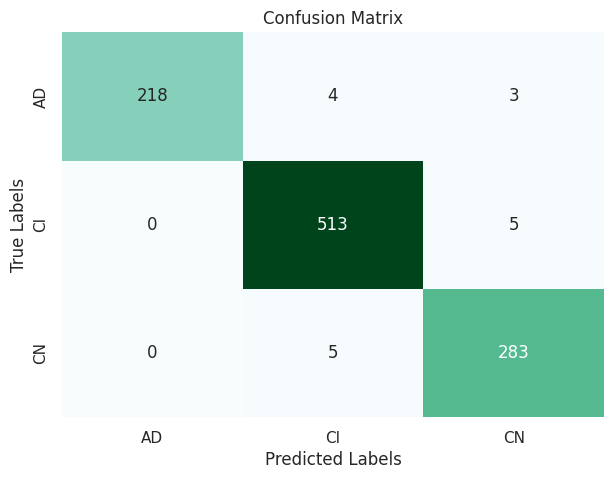

In [53]:
# Plot confusion matrix
plt.figure(figsize=(7, 5))
conf_matrix = confusion_matrix(y_test, y_pred)
# unique_labels = np.unique(np.concatenate((y_test, y_pred)))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuGn', cbar=False, xticklabels=['AD', 'CI', 'CN'], yticklabels=['AD', 'CI', 'CN'])
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [54]:
observations = {'Model': ['CNN', 'Extra Trees', 'Ensemble AutoEncoder-ET'],
                'Accuracy': [acc_cnn, acc_et, acc_encoder],
                'F1-score': [f1_cnn, f1_et, f1_encoder],
                'Recall': [rec_cnn, rec_et, rec_encoder],
                'Precision': [prec_cnn, prec_et, prec_encoder]}

observations_data = pd.DataFrame(observations)
observations_data

,Model,Accuracy,F1-score,Recall,Precision
0,CNN,0.756547,0.755540,0.756547,0.757012
1,Extra Trees,0.994180,0.994174,0.994180,0.994224
2,Ensemble AutoEncoder-ET,0.983511,0.983516,0.983511,0.983658


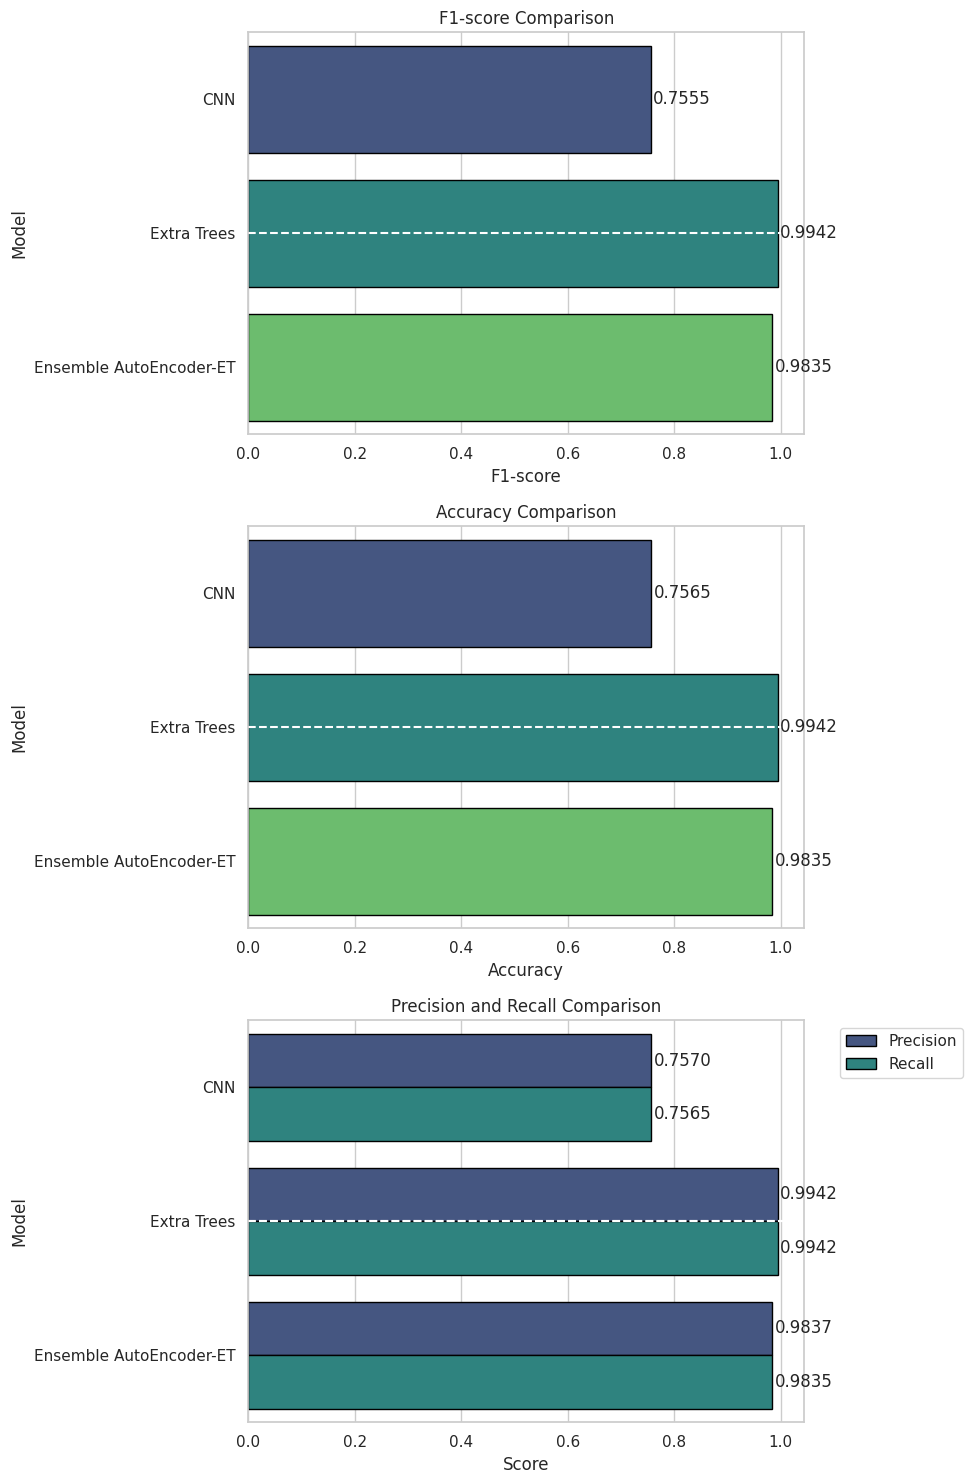

In [55]:
# Set color palette
colors = sns.color_palette('viridis', n_colors=len(observations_data))

# Sort DataFrame by F1-score for better visualization
observation_data = observations_data.sort_values(by='F1-score', ascending=False)

# Create subplots for F1-score, Accuracy, and Precision/Recall
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot F1-score
sns.barplot(x='F1-score', y='Model', data=observations_data, palette=colors, edgecolor='black', ax=axes[0])
axes[0].set_title('F1-score Comparison')
axes[0].set_xlabel('F1-score')
axes[0].set_ylabel('Model')


# Plot Accuracy
sns.barplot(x='Accuracy', y='Model', data=observations_data, palette=colors, edgecolor='black', ax=axes[1])
axes[1].set_title('Accuracy Comparison')
axes[1].set_xlabel('Accuracy')
axes[1].set_ylabel('Model')

# Plot Precision and Recall
precision_recall_data = observations_data.melt(id_vars='Model', value_vars=['Precision', 'Recall'])
sns.barplot(x='value', y='Model', hue='variable', data=precision_recall_data, palette=colors, edgecolor='black', ax=axes[2])
axes[2].set_title('Precision and Recall Comparison')
axes[2].set_xlabel('Score')
axes[2].set_ylabel('Model')
axes[2].legend(title=None, bbox_to_anchor=(1.05, 1), loc='upper left')

# Add red marker vertical line to the head of the highest bar in F1-score chart
max_f1_index = observations_data['F1-score'].idxmax()
axes[0].axhline(y=max_f1_index, color='white', linestyle='--')

max_acc_index = observations_data['Accuracy'].idxmax()
axes[1].axhline(y=max_acc_index, color='white', linestyle='--')

max_prec_index = observations_data['Precision'].idxmax()
axes[2].axhline(y=max_prec_index, color='white', linestyle='--')

max_rec_index = observations_data['Recall'].idxmax()
axes[2].axhline(y=max_rec_index, color='white', linestyle='--')


# Add annotations to each bar
for ax in axes:
    for i, bar in enumerate(ax.patches):
        ax.text(
            bar.get_width() + 0.005,
            bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.4f}',
            va='center'
        )

plt.tight_layout()
plt.show()
